# Centrality measures

Much of this content is based heavily on Section 7.1 from Mark Newman's "Networks"
{cite:p}`newman2018networks`. 

Lots of research has gone into studying various notions of a "how important is each node?" in 
a network. Of course, as this vague question suggests, there are many ways to define 
what we mean by important. Below, we'll cover a few of the most famous and commonly 
used notions, primarily because it will be useful to know what these terms mean when 
reading studies which use network science. Also, many of these methods are based on
elegant and relatively simple mathematics. 

In [88]:
import networkx as nx
import numpy as np
from graspologic.datasets import load_drosophila_left
from graspologic.utils import binarize


A = load_drosophila_left()[:28, :28]
A = binarize(A).astype(int)
g = nx.from_numpy_array(A, create_using=nx.DiGraph)

# g = nx.karate_club_graph()

# nodelist = list(g.nodes)
# A = nx.to_numpy_array(g, nodelist=nodelist).astype(int)


def map_to_nodes(node_map):
    node_map.setdefault(0)
    # utility function to make it easy to compare dicts to array outputs
    return np.array(np.vectorize(lambda x: node_map.setdefault(x, 0))(nodelist))

## Degrees

The first notion of centrality we'll consider is the node's [**degree**](https://en.wikipedia.org/wiki/Degree_(graph_theory)), sometimes called **degree centrality**, 
though I personally won't use that term. The degree of a node is simply the number of other nodes to which it
is connected.



In [89]:
degrees = dict(g.degree())
map_to_nodes(degrees)

array([49, 50, 51, 52, 52, 52, 47, 49, 49, 47, 46, 48, 50, 46, 52, 51, 50,
       46, 49, 52, 50, 50, 42, 47, 34, 41, 38, 48,  0,  0,  0,  0,  0,  0])

This output is essentially a dictionary mapping each node in the network to its degree.

Computing the degree is also quite easy with the adjacency matrix:

In [90]:
A.sum(axis=0) + A.sum(axis=1)

array([49, 50, 51, 52, 52, 52, 47, 49, 49, 47, 46, 48, 50, 46, 52, 51, 50,
       46, 49, 52, 50, 50, 42, 47, 34, 41, 38, 48])

We see that the output matches, as expected. For a directed network, there are distinct 
notions of degree based on whether we are considering a node's outputs or inputs. These 
are simply termed **[out and in degree](https://en.wikipedia.org/wiki/Directed_graph#Indegree_and_outdegree)**, where
out degree is the number of outputs from a given node, and likewise for the in degree.

Let's see what this looks like to compute using `networkx` and an adjacency matrix:

In [91]:
out_degrees = A.sum(axis=1)
out_degrees

array([24, 26, 26, 26, 25, 25, 24, 26, 26, 23, 25, 25, 24, 23, 25, 26, 23,
       23, 24, 25, 26, 25, 22, 24, 17, 22, 18, 21])

In [92]:
map_to_nodes(dict(g.out_degree()))

array([24, 26, 26, 26, 25, 25, 24, 26, 26, 23, 25, 25, 24, 23, 25, 26, 23,
       23, 24, 25, 26, 25, 22, 24, 17, 22, 18, 21,  0,  0,  0,  0,  0,  0])

In [93]:
in_degrees = A.sum(axis=0)
in_degrees

array([25, 24, 25, 26, 27, 27, 23, 23, 23, 24, 21, 23, 26, 23, 27, 25, 27,
       23, 25, 27, 24, 25, 20, 23, 17, 19, 20, 27])

In [94]:
map_to_nodes(dict(g.in_degree()))

array([25, 24, 25, 26, 27, 27, 23, 23, 23, 24, 21, 23, 26, 23, 27, 25, 27,
       23, 25, 27, 24, 25, 20, 23, 17, 19, 20, 27,  0,  0,  0,  0,  0,  0])

## Eigenvector centrality

Our next notion of importance for each node is called **[eigenvector centrality](https://en.wikipedia.org/wiki/Eigenvector_centrality)**. The eigenvector centrality has an interesting, circular definition: nodes are considered more important if they themselves are connected to many important nodes. 

How can we write this down mathematically? Let's say that we are after a vector $x$, which 
has length $n$ (the number of nodes in our graph). Element $x_i$ in this vector will 
represent the eigenvector centrality that we are after for node $i$. Based on what we 
said about in the definition, then this means that we can write: 

$$x_i = c \sum A_{ij} x_j$$

How does this work? For any potential edge incident to $i$ that doesn't exist, $A_{ij} = 0$, 
and thus we won't sum up the contribution of those nodes which aren't neighbors of $i$. 
Why do we have a constant, $c$? Since the definition of eigenvector centrality is completely
*relative*, we could put any constant $c > 0$, and the definition would hold. Since this 
choice is relative, let's set $c = \frac{1}{\lambda}$, where $\lambda$ is the largest eigenvalue
of $A$. 

$$x_i = \frac{1}{\lambda} \sum A_{ij} x_j$$

Now, this formula is starting to look like something we know from linear algebra. We
can rewrite this set of equations (for all $i$) as a matrix/vector equation: 

$$\lambda x = A x$$

Which is the familiar definition of an eigenvector/eigenvalue, where in this case, $x$
would correspond to the eigenvector of the largest eigenvalue of $A$. Why are we considering
only the largest eigenvalue of $A$, rather than any other? This is because if we want a 
positive score for each node in our network, the only eigenvector with all positive elements
will be the one we chose above, by a famous result called the [Perron-Frobenius theorem](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem). 



Knowing this, we can compute the eigenvector centrality quite easily from the adjacency matrix.

In [95]:
g = nx.karate_club_graph()
nodelist = list(g.nodes)
A = nx.to_numpy_array(g, nodelist=nodelist)

eigenvalues, eigenvectors = np.linalg.eig(A)
first_eigenvector = np.abs(eigenvectors[:, 0])
first_eigenvector

array([0.35549144, 0.26595992, 0.3171925 , 0.21117972, 0.07596882,
       0.07948305, 0.07948305, 0.17095975, 0.22740391, 0.10267425,
       0.07596882, 0.0528557 , 0.08425463, 0.22647272, 0.10140326,
       0.10140326, 0.02363563, 0.09239954, 0.10140326, 0.14791251,
       0.10140326, 0.09239954, 0.10140326, 0.15011857, 0.05705244,
       0.05920647, 0.07557941, 0.13347715, 0.13107782, 0.13496082,
       0.1747583 , 0.19103384, 0.30864422, 0.37336347])

The eigenvector centrality is also provided as a function directly in `networkx`.

In [96]:
map_to_nodes(dict(nx.eigenvector_centrality(g)))

array([0.35548349, 0.26595387, 0.31718939, 0.21117408, 0.07596646,
       0.07948058, 0.07948058, 0.17095511, 0.22740509, 0.10267519,
       0.07596646, 0.05285417, 0.08425192, 0.2264697 , 0.10140628,
       0.10140628, 0.02363479, 0.09239676, 0.10140628, 0.14791134,
       0.10140628, 0.09239676, 0.10140628, 0.15012329, 0.05705374,
       0.0592082 , 0.07558192, 0.13347933, 0.13107926, 0.13496529,
       0.17476028, 0.19103627, 0.30865105, 0.37337121])

## PageRank

See the [Wikipedia article on PageRank](https://en.wikipedia.org/wiki/PageRank) for more detail than I give here.

PageRank is another famous centrality measure - famous because it was one of the algorithms used early on by Google to decide which websites in a web network were important.

There are several ways to derive the definition of PageRank, but we'll use one based on something called **[random walks](https://en.wikipedia.org/wiki/Random_walk)** to motivate this algorithm.



### Random walks

![](./images/random-walk.png)

Let's say we have an unweighted, directed network (for the time being). At time $t$, imagine you are a placed at a random node in a network, node $i$. To decide your position at time $t+1$, you *randomly* chose one of the outbound links from node $A$ to follow.

Let $x^{t+1}$ be an $n$-length vector, with all 0s except for a $1$ at the position
of our random walker at time $t+1$.

We can write the probability of being at node $j$ at time $t=1$ as:

$P[x_j^{t+1} = 1] = A_{ij}/d_{i}$

In other words, this probability is $1 / d_{i}$ if $i$ is connected to $j$, and 0 otherwise.

Random walks are a very important concept in network science which we'll come back to later in the course. 

Rather than considering a single random walker (e.g. the vector $x$ has 0's and 1's), it
is often more useful to consider the *probability distribution* of a random walker. In 
other words, we can consider the vector $x^{t}$ to be positive and sum to 1, and element
$x_i^{t}$ represents the probability of being at node $i$ and time $t$. 

Let $D$ be an $n \times n$ matrix whose diagonal is the out degree of each node. Now, we 
can create a matrix $P$ which represents the **transition probabilities** for our random walk:
$$P = D^{-1} A$$

In essence, we have just divided each row of $A$ by its out degree.

Now, we can use a simple matrix/vector equation to update the probability distribution of 
our random walker at time $t+1$ based on that at time $t$.

$$x^{(t+1)} = A^T D^{-1} x^{(t)} = P^T x^{(t)}$$

### Random walks with teleportation

One issue with the model above is that sometimes a random walker could get stuck in a 
node with no output edges. The authors of PageRank made one small modification to this random 
walk scheme - at each time step, with probability $\alpha$ the random walk proceeds as before. With probability $1 - \alpha$, the random walker *teleports* to node completely at random.

Now, we have

$$x^{(t+1)} = \alpha A^T D^{-1} x^{(t)} + \frac{(1 - \alpha)}{n} x^{(t)}$$
$$x^{(t+1)} = \left (\alpha A^T D^{-1} + \frac{(1 - \alpha)}{n} \right ) x^{(t)}$$

Given this, we are basically done finding the PageRank of each node! The logic of PageRank
is simply to give an importance to each node which is proportional to the limiting probability
of this random walker (with teleportation) landing on that node after a long time walking 
on our network. Because of some linear algebraic properties which we probably won't get 
into in this course, this limiting distribution (e.g. $x^{(t)}$ as $t$ goes to infinity)
converges in a modest number of iterations because of the teleportation probability we added. 
The value of $\alpha$ can be set by the user, but typically people leave it at $0.85$.

In [97]:
n = A.shape[0]
alpha = 0.85
n_iters = 100
out_degrees = A.sum(axis=1)
D_inv = np.diag(1 / out_degrees)
rng = np.random.default_rng()
x = rng.random(n)
x /= np.linalg.norm(x, ord=1)
P = A.T @ D_inv
P_mod = alpha * P + (1 - alpha) / n

for i in range(n_iters):
    x = P_mod @ x

x

array([0.09699729, 0.05287692, 0.05707851, 0.03585986, 0.02197795,
       0.02911115, 0.02911115, 0.0244905 , 0.02976606, 0.0143094 ,
       0.02197795, 0.00956475, 0.01464489, 0.02953646, 0.01453599,
       0.01453599, 0.01678401, 0.01455868, 0.01453599, 0.01960464,
       0.01453599, 0.01455868, 0.01453599, 0.03152251, 0.02107603,
       0.0210062 , 0.01504404, 0.02563977, 0.01957346, 0.02628854,
       0.02459016, 0.03715809, 0.07169323, 0.10091918])

Note that this is algorithm also has an interpretation as finding the principal eigenvector
of the matrix `P_mod` above through a process known as [power iteration](https://en.wikipedia.org/wiki/Power_iteration).

The algorithm we used above gets a very similar answer to the version implemented in `networkx`. There are a couple of parameters (max iterations, stopping tolerance, initial distribution) which can affect the results slightly. 

In [98]:
pagerank_dict = nx.pagerank(g, max_iter=100)
np.vectorize(pagerank_dict.get)(nodelist)

array([0.09700182, 0.05287839, 0.05707842, 0.03586064, 0.02197941,
       0.02911334, 0.02911334, 0.02449076, 0.02976534, 0.01430895,
       0.02197941, 0.00956492, 0.01464519, 0.02953631, 0.01453516,
       0.01453516, 0.01678538, 0.01455886, 0.01453516, 0.01960442,
       0.01453516, 0.01455886, 0.01453516, 0.03152092, 0.02107546,
       0.02100563, 0.0150434 , 0.0256388 , 0.01957296, 0.02628726,
       0.02458934, 0.03715664, 0.07169213, 0.10091792])

## Betweenness centrality

Rather than considering random walks, **betweenness centrality** is based on **shortest paths**. A shortest path between node $i$ and node $j$ is a path (a sequence of edges to traverse) which uses as few edges as possible to get from $i$ to $j$. If you'd like to compute shortest paths with a sparse adjacency matrix, you can do this in `scipy` using [`scipy.sparse.csgraph.shortest_path`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.shortest_path.html).

Betweenness centrality uses the following motivation: imaging we have a network where every pair of nodes needs to exchange information. Further, we assume that each node is equally efficient at transmitting information, and that information will flow between pairs of nodes using the shortest path.

Betweenness centrality, then, is based on the following simple logic: a node is more important if more information passes through them. In other words, the betweenness centrality of node $i$ is proportional to the number of these shortest paths (among all other nodes) which contain $i$.

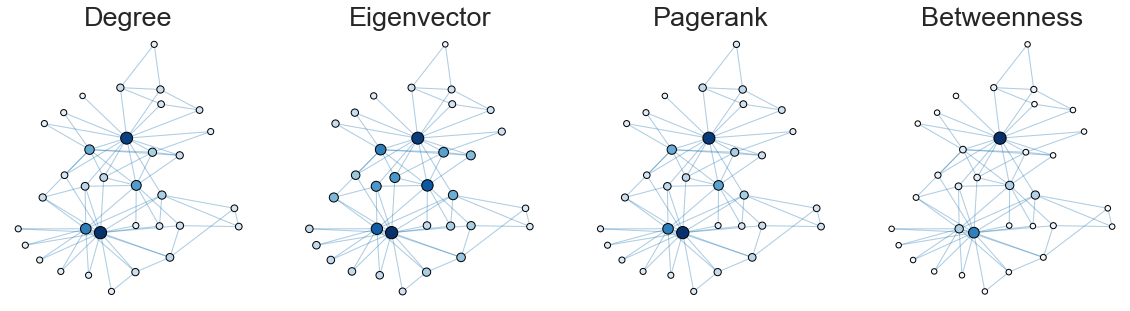

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from graspologic.plot import networkplot
import seaborn as sns
from matplotlib import colors

node_data = pd.DataFrame(index=g.nodes())
node_data["degree"] = node_data.index.map(dict(nx.degree(g)))
node_data["eigenvector"] = node_data.index.map(nx.eigenvector_centrality(g))
node_data["pagerank"] = node_data.index.map(nx.pagerank(g))
node_data["betweenness"] = node_data.index.map(nx.betweenness_centrality(g))

pos = nx.kamada_kawai_layout(g)
node_data["x"] = [pos[node][0] for node in node_data.index]
node_data["y"] = [pos[node][1] for node in node_data.index]

sns.set_context("talk", font_scale=1.5)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))


def plot_node_scaled_network(A, node_data, key, ax):
    # REF: https://github.com/mwaskom/seaborn/blob/9425588d3498755abd93960df4ab05ec1a8de3ef/seaborn/_core.py#L215

    levels = list(np.sort(node_data[key].unique()))
    cmap = sns.color_palette("Blues", as_cmap=True)
    vmin = np.min(levels)
    norm = colors.Normalize(vmin=0.3 * vmin)
    palette = dict(zip(levels, cmap(norm(levels))))

    networkplot(
        A,
        node_data=node_data,
        x="x",
        y="y",
        ax=ax,
        edge_linewidth=1.0,
        node_size=key,
        node_hue=key,
        palette=palette,
        node_sizes=(30, 150),
        node_kws=dict(linewidth=1, edgecolor="black"),
        node_alpha=1.0,
        edge_kws=dict(color=sns.color_palette()[0])
    )

    ax.axis("off")
    ax.set_title(key.capitalize())


ax = axs[0]
plot_node_scaled_network(A, node_data, "degree", ax)

ax = axs[1]
plot_node_scaled_network(A, node_data, "eigenvector", ax)

ax = axs[2]
plot_node_scaled_network(A, node_data, "pagerank", ax)

ax = axs[3]
plot_node_scaled_network(A, node_data, "betweenness", ax)

fig.set_facecolor("w")

In [100]:
node_data

,degree,eigenvector,pagerank,betweenness,x,y
0,16,0.355483,0.097002,0.437635,0.025953,0.332618
1,9,0.265954,0.052878,0.053937,-0.154154,0.251060
2,10,0.317189,0.057078,0.143657,0.072811,-0.003398
3,6,0.211174,0.035861,0.011909,0.151208,0.232506
4,3,0.075966,0.021979,0.000631,0.193135,0.574454
5,4,0.079481,0.029113,0.029987,0.189964,0.679017
6,4,0.079481,0.029113,0.029987,-0.004422,0.691958
7,4,0.170955,0.024491,0.000000,0.283520,0.210236
8,5,0.227405,0.029765,0.055927,-0.175658,-0.009901
9,2,0.102675,0.014309,0.000848,0.070613,-0.289252


## References 
```{bibliography}
:style: unsrt
```